# AutoModelizer
---

La idea de este proyecto es encontrar el mejor modelo de CNN que se adapte al dataset correspondiente, para ello usando algoritmos evolutivos. Este tipo de soluciones se conocen como neuroevoluciones

A continuación un ejemplo básico de como funcionan este tipo de algoritmos

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

def fitness(x):
    return x ** 2

population_size = 10
population = np.random.uniform(-10, 10, population_size)

In [2]:
def select_parent_tournament(population, scores, k=3):
    selection_ix = np.random.randint(len(population), size=k)
    selected = population[selection_ix]
    ix = np.argmax(scores[selection_ix])
    return selected[ix]

def crossover_test(p1, p2):
    child = (p1 + p2) / 2
    return child

def mutate(x):
    mutation_chance = 0.1
    if np.random.rand() < mutation_chance:
        x += np.random.uniform(-1, 1)
    return x

In [3]:
n_generations = 200

for generation in range(n_generations):
    scores = np.array([fitness(x) for x in population])
    new_population = []
    for _ in range(population_size):
        parent1 = select_parent_tournament(population, scores)
        parent2 = select_parent_tournament(population, scores)
        child = crossover_test(parent1, parent2)
        child = mutate(child)
        new_population.append(child)
    population = np.array(new_population)
    best_score = np.max(scores)
    print(f"Generación {generation}, x = {child} Mejor puntuación {best_score}")

best_solution = population[np.argmax(scores)]
print(f"Mejor solución: x = {best_solution}, f(x) = {fitness(best_solution)}")


Generación 0, x = -0.9183337529939948 Mejor puntuación 96.2425680255805
Generación 1, x = -8.593400938020785 Mejor puntuación 85.07431122598958
Generación 2, x = -8.750944120745524 Mejor puntuación 79.74839477044402
Generación 3, x = -8.930195673692936 Mejor puntuación 79.74839477044402
Generación 4, x = -8.953954059785891 Mejor puntuación 82.21662243853557
Generación 5, x = -9.17857059380556 Mejor puntuación 83.18376082186869
Generación 6, x = -9.05964006826867 Mejor puntuación 84.24615814547215
Generación 7, x = -9.17857059380556 Mejor puntuación 100.58557906009075
Generación 8, x = -9.4374482352009 Mejor puntuación 92.23496060292985
Generación 9, x = -9.585713653420843 Mejor puntuación 91.88590624537876
Generación 10, x = -9.532547052084277 Mejor puntuación 91.88590624537876
Generación 11, x = -9.559130352752561 Mejor puntuación 91.88590624537876
Generación 12, x = -9.807004600766422 Mejor puntuación 100.566711600283
Generación 13, x = -9.571813770462722 Mejor puntuación 100.5667116

Preparamos el dataset de prueba (MNIST)
---

---

In [4]:
## indicamos la máxima descendencia que queremos 
# uso 2 para simplemente comprobar que el algoritmo al completo funciona, este valor lo 
# indicará el usuario desde la interfaz
max_desc = 20

In [5]:
# DATOS DEL DATASET DE PRUEBA

num_channels = 1 # escala de grises
px_h = 28
px_w = 28
batch_size = 32
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparar los DataLoader para los conjuntos de entrenamiento y validación
transform = transforms.Compose([
    transforms.Resize((px_h, px_w)),
    transforms.Grayscale(num_output_channels=num_channels),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


Preparamos el dataset de prueba (CIFAR100)
---

---

In [6]:

# DATOS DEL DATASET DE PRUEBA CIFAR 100
num_channels = 3 # escala de colores
px_h = 32
px_w = 32
batch_size = 128
num_classes = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparar los DataLoader para los conjuntos de entrenamiento y validación
transform = transforms.Compose([
    transforms.Resize((px_h, px_w)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


## GENERACIÓN DE LA RED EN BASE A VECTORES


---

comprobamos si tenemos acceso a la GPU


In [7]:
if torch.cuda.is_available():
    print("CUDA (GPU) está disponible en tu sistema.")
else:
    print("CUDA (GPU) no está disponible en tu sistema.")

CUDA (GPU) está disponible en tu sistema.


Construimos una función que sea capaz de crear modelos en base a vectores que representen la arquitectura de la red.
De este modo el algorimo evolutivo puede ir adaptando y cambiando la red fácilmente

In [8]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
filter_range = [8,16,32,64,128]
kernel_size_range = [1,3,5,7] 

In [9]:
import torch

def build_cnn_from_individual(individual):
    """ 
    Funcion para construir un modelo en base a un diccionario
    """
    layers = []
    num_layers = individual['num_conv_layers']
    fully_connected = int(individual['fully_connected'])
    dropout = individual['dropout']
    out_channels_previous_layer = num_channels

    for i in range(num_layers):
        out_channels = individual['filters'][i]
        kernel_size = individual['kernel_sizes'][i]
        
        conv_layer = nn.Conv2d(out_channels_previous_layer, out_channels, kernel_size=kernel_size, padding=1)
        layers.append(conv_layer)
        if out_channels_previous_layer > 1 or i > 0:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        if i < 1:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=1))


        out_channels_previous_layer = out_channels


    # Temporalmente crear un modelo para calcular el tamaño de salida de las capas convolucionales
    temp_model = nn.Sequential(*layers)

    # Calcular el tamaño de salida usando un tensor dummy
    dummy_input = torch.zeros(1, num_channels, px_h, px_w)
    output_size = temp_model(dummy_input).view(-1).shape[0]

    # Ahora, sabiendo el tamaño de salida, podemos definir las capas lineales correctamente
    layers.append(nn.Flatten())

    for i in range(fully_connected):
        layers.append(nn.Linear(in_features=output_size, out_features=output_size))
        if dropout > 0:
            layers.append(nn.Dropout(0.2))
            dropout-= 1

    layers.append(nn.Linear(output_size, num_classes))
    return nn.Sequential(*layers)


Definimos una función para generar diccionarios para la población inicial

In [10]:
import random
from tqdm import tqdm

def generate_individual(min_conv_layers, max_conv_layers, min_filters, max_filters, kernel_sizes):
    """ 
    Funcion para generar un diccionario que representa a una arquitectura
    """
    individual = {
        'num_conv_layers': random.randint(min_conv_layers, max_conv_layers),
        'filters': [],
        'kernel_sizes': [],
        'learning_rate': random.choice(learning_rates),
        'fully_connected': random.randint(0,2),
        'dropout': random.randint(0,2)
    }

    for _ in range(individual['num_conv_layers']):
        individual['filters'].append(random.choice(filter_range))
        individual['kernel_sizes'].append(random.choice(kernel_size_range))
    
    # Agrega más parámetros según sea necesario, como capas completamente conectadas, etc.

    return individual

def initialize_population(pop_size, min_conv_layers, max_conv_layers, min_filters, max_filters, kernel_sizes):
    return [generate_individual(min_conv_layers, max_conv_layers, min_filters, max_filters, kernel_sizes) for _ in range(pop_size)]


### PARAMETROS PARA POSIBLES ARQUITECTURAS DE RED
---

In [11]:
## AJUSTAR SEGÚN VAYA NECESITANDO Y TIEMPO 

population_size = 6
min_conv_layers = 1
max_conv_layers = 3
min_filters = 16
max_filters = 128
kernel_sizes = [3, 5]

In [12]:


population = initialize_population(population_size, min_conv_layers, max_conv_layers, min_filters, max_filters, kernel_sizes)

epochs = 7 

population


[{'num_conv_layers': 1,
  'filters': [8],
  'kernel_sizes': [1],
  'learning_rate': 0.1,
  'fully_connected': 2,
  'dropout': 0},
 {'num_conv_layers': 2,
  'filters': [32, 64],
  'kernel_sizes': [3, 3],
  'learning_rate': 1e-05,
  'fully_connected': 0,
  'dropout': 2},
 {'num_conv_layers': 3,
  'filters': [8, 128, 16],
  'kernel_sizes': [7, 5, 7],
  'learning_rate': 0.001,
  'fully_connected': 2,
  'dropout': 1},
 {'num_conv_layers': 2,
  'filters': [32, 16],
  'kernel_sizes': [7, 7],
  'learning_rate': 0.0001,
  'fully_connected': 1,
  'dropout': 2},
 {'num_conv_layers': 3,
  'filters': [8, 32, 32],
  'kernel_sizes': [5, 1, 3],
  'learning_rate': 0.001,
  'fully_connected': 0,
  'dropout': 2},
 {'num_conv_layers': 2,
  'filters': [128, 64],
  'kernel_sizes': [1, 7],
  'learning_rate': 1e-06,
  'fully_connected': 0,
  'dropout': 1}]

## ENTRENAMIENTO Y EVALUACIÓN DE LOS MODELOS
---

In [13]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

def evaluate_individual(individual, train_loader, val_loader, device='cuda', epochs=5):
    """ 
    Funcion para entrenar y evaluar una arquitectura
    """
    # Construir el modelo basado en el individuo
    model = build_cnn_from_individual(individual).to(device)
    
    # Definir el optimizador y la función de pérdida
    # HACER QUE EL OPTIMIZADOR SEA OTRO GEN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    optimizer = torch.optim.Adam(model.parameters(), lr=individual['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    # Entrenamiento
    for epoch in range(epochs):
        model.train()
        progress_bar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch')
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            # Actualizar la barra de progreso con la última información de pérdida
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})
            progress_bar.update()  # Forzar la actualización de la barra de progreso
            
        progress_bar.close()  # Cerrar la barra de progreso al final de cada época

    # Evaluación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return accuracy  # Esta es la "aptitud" del individuo


## MUTACIONES Y CRUCES
---

In [14]:
import random

def mutate_individual(individual):
    """
    Mutar un individuo cambiando aleatoriamente sus hiperparámetros.
    """
    mutation_rate = 0.3  # Probabilidad de mutar cada característica
    fully_connected_range = (0,5) #Rango para ver cuantas fully conected se añaden

    if random.random() < mutation_rate:
        # Mutar la tasa de aprendizaje
        individual['learning_rate'] = random.choice(learning_rates)


    # Asegurarse de que hay suficientes entradas en las listas 'filters' y 'kernel_sizes'
    for i in range(individual['num_conv_layers']):
        if random.random() < mutation_rate:
            # Mutar el número de filtros en la capa i
            individual['filters'][i] = random.choice(filter_range)
        if random.random() < mutation_rate:
            # Mutar el tamaño de filtro en la capa i
            individual['kernel_sizes'][i] = random.choice(kernel_size_range)

    if random.random() < mutation_rate:
        # Mutar la tasa de aprendizaje
        num_fully = random.randint(*fully_connected_range)
        individual['fully_connected'] = num_fully
        individual['dropout'] = random.randint(0, num_fully)
    return individual


Y el cruce entre individuos

In [15]:
def crossover(parent1, parent2):
    """
    Realiza un cruce uniforme entre dos individuos.
    
    Args:
        parent1 (dict): El primer individuo padre.
        parent2 (dict): El segundo individuo padre.
    
    Returns:
        dict: Un nuevo individuo hijo.
    """
    child = {}
    for key in parent1:
        if key == "filters" or key == "kernel_sizes":
            if random.random() < 0.5:
                child["filters"] = parent1["filters"]
                child["kernel_sizes"] = parent1["kernel_sizes"]
            else:
                child["filters"] = parent2["filters"]
                child["kernel_sizes"] = parent2["kernel_sizes"]

        else:
            if key != "num_conv_layers":
                if random.random() < 0.5:
                    child[key] = parent1[key]
                else:
                    child[key] = parent2[key]
    child["num_conv_layers"] = len(child["filters"])

    return child

Definimos como evaluamos a la población 

In [16]:
def evaluate_population(population, train_loader, val_loader, device, epochs):
    """
    Funcion para evaluar a una poblacion de arquitecturas
    """
    fitness_scores = []
    
    for individual in population:
        print(individual)
        fitness = evaluate_individual(individual, train_loader, val_loader, device, epochs)
        fitness_scores.append(fitness)
    
    # sacamos los scores de la poblacion
    return fitness_scores




Recopilamos lo que hemos realizado, hemos creado las posibles mutaciones sobre las arquitecturas, los posibles cruces, la evaluación de los modelos.


Queda realizar:
- Selección de reproducción: por torneo en principio para también  puede ser por torneo o ruleta
- Creación de la nueva generación usando las funciones de mutación y cruces
- Criterios de parada
- Registro de análisis

### Selección por torneo
---


In [17]:
def tournament_selection_best5(population):
    """
    Selecciona los 4 mejores individuos de la población mediante un torneo de tamaño fijo.

    Args:
        population: La lista de individuos con sus puntuaciones de fitness.

    Returns:
        Lista de los 4 mejores individuos.
    """
    winners = []
    for _ in range(5):
        candidates = random.sample(population, 2)
        winner = max(candidates, key=lambda x: x['fitness'])
        winners.append(winner)
    return winners

## ALGORITMO EVOLUTIVO
--- 


In [18]:
"""
fitness_scores = evaluate_population(population, train_loader, val_loader, device)

# Almacenamos- los individuos y sus puntuaciones en una lista de tuplas y ordenarlos
population_with_scores = list(zip(population, fitness_scores))
population_with_scores.sort(key=lambda x: x[1], reverse=True)  # Ordena de mayor a menor aptitud

# Imprimimimos los resultados
for i, (individual, score) in enumerate(population_with_scores):
    print(f"Descendecia: {i} Individuo {individual}: Pérdida: {score}")

"""

'\nfitness_scores = evaluate_population(population, train_loader, val_loader, device)\n\n# Almacenamos- los individuos y sus puntuaciones en una lista de tuplas y ordenarlos\npopulation_with_scores = list(zip(population, fitness_scores))\npopulation_with_scores.sort(key=lambda x: x[1], reverse=True)  # Ordena de mayor a menor aptitud\n\n# Imprimimimos los resultados\nfor i, (individual, score) in enumerate(population_with_scores):\n    print(f"Descendecia: {i} Individuo {individual}: Pérdida: {score}")\n\n'

In [19]:
top_models = []

def genetic_algorithm(population, train_loader, val_loader, device, max_desc, epochs):
    """ 
    Algoritmo genetico para evolucionar una poblacion de arquitecturas hacia la mejor puntuacion dado un dataset dado
    """
    desc = 0
    while desc < max_desc:
        print("***************************************")
        print()
        print(f"Generation: {desc}")
        print()
        print("***************************************")
        puntuaciones_aptitud = evaluate_population(population, train_loader, val_loader, device, epochs)

        # Ordenamos individuos
        # Añadimos las puntuaciones directamente a cada diccionario de la población
        for i, puntuacion in enumerate(puntuaciones_aptitud):
            population[i]['fitness'] = puntuacion

        population.sort(key=lambda x: x['fitness'], reverse=True)

        # Preservamos el mejor individuo (elitismo)
        mejor_individuo = population[0]
        top_models.append(mejor_individuo)
        # Seleccionamos los 4 mejores (excluyendo el mejor) para el torneo
        winners = tournament_selection_best5(population[1:])
        print(f"Los 4 mejores son: \n {winners}")

        # Realizamos cruce y mutación con descendientes que reemplazan a la población restante
        for i in range(1, 5):
            descendency = mutate_individual(crossover(winners[i-1], winners[i]))
            population[-i] = descendency   # Eliminamos las peores arquitecturas
        
        # Nos aseguramos que mantenemos el mejor de todos
        population[0] = mejor_individuo
        desc += 1

    return population


## RESULTADOS DE LAS ARQUITECTURAS
---

In [20]:
population_sol = genetic_algorithm(population, train_loader, val_loader, device, max_desc, epochs)

***************************************

Generation: 0

***************************************
{'num_conv_layers': 1, 'filters': [8], 'kernel_sizes': [1], 'learning_rate': 0.1, 'fully_connected': 2, 'dropout': 0}


Epoch 7/7: 100%|██████████| 391/391 [00:13<00:00, 27.96batch/s, training_loss=52.577] 


{'num_conv_layers': 2, 'filters': [32, 64], 'kernel_sizes': [3, 3], 'learning_rate': 1e-05, 'fully_connected': 0, 'dropout': 2}


Epoch 7/7: 100%|██████████| 391/391 [00:13<00:00, 28.44batch/s, training_loss=2.877]


{'num_conv_layers': 3, 'filters': [8, 128, 16], 'kernel_sizes': [7, 5, 7], 'learning_rate': 0.001, 'fully_connected': 2, 'dropout': 1}


Epoch 7/7: 100%|██████████| 391/391 [00:14<00:00, 27.86batch/s, training_loss=2.395]


{'num_conv_layers': 2, 'filters': [32, 16], 'kernel_sizes': [7, 7], 'learning_rate': 0.0001, 'fully_connected': 1, 'dropout': 2}


Epoch 7/7: 100%|██████████| 391/391 [00:13<00:00, 28.46batch/s, training_loss=2.498]


{'num_conv_layers': 3, 'filters': [8, 32, 32], 'kernel_sizes': [5, 1, 3], 'learning_rate': 0.001, 'fully_connected': 0, 'dropout': 2}


Epoch 7/7: 100%|██████████| 391/391 [00:13<00:00, 29.07batch/s, training_loss=1.603]


{'num_conv_layers': 2, 'filters': [128, 64], 'kernel_sizes': [1, 7], 'learning_rate': 1e-06, 'fully_connected': 0, 'dropout': 1}


Epoch 7/7: 100%|██████████| 391/391 [00:16<00:00, 24.02batch/s, training_loss=3.891]


Los 4 mejores son: 
 [{'num_conv_layers': 3, 'filters': [8, 128, 16], 'kernel_sizes': [7, 5, 7], 'learning_rate': 0.001, 'fully_connected': 2, 'dropout': 1, 'fitness': 0.3337}, {'num_conv_layers': 2, 'filters': [32, 64], 'kernel_sizes': [3, 3], 'learning_rate': 1e-05, 'fully_connected': 0, 'dropout': 2, 'fitness': 0.308}, {'num_conv_layers': 3, 'filters': [8, 128, 16], 'kernel_sizes': [7, 5, 7], 'learning_rate': 0.001, 'fully_connected': 2, 'dropout': 1, 'fitness': 0.3337}, {'num_conv_layers': 2, 'filters': [128, 64], 'kernel_sizes': [1, 7], 'learning_rate': 1e-06, 'fully_connected': 0, 'dropout': 1, 'fitness': 0.1559}, {'num_conv_layers': 2, 'filters': [32, 16], 'kernel_sizes': [7, 7], 'learning_rate': 0.0001, 'fully_connected': 1, 'dropout': 2, 'fitness': 0.3483}]
***************************************

Generation: 1

***************************************
{'num_conv_layers': 3, 'filters': [8, 32, 32], 'kernel_sizes': [5, 1, 3], 'learning_rate': 0.001, 'fully_connected': 0, 'dropou

Epoch 7/7: 100%|██████████| 391/391 [00:13<00:00, 29.17batch/s, training_loss=1.660]


{'num_conv_layers': 2, 'filters': [32, 16], 'kernel_sizes': [7, 7], 'learning_rate': 0.0001, 'fully_connected': 1, 'dropout': 2, 'fitness': 0.3483}


Epoch 7/7: 100%|██████████| 391/391 [00:13<00:00, 28.73batch/s, training_loss=2.315]


{'filters': [32, 64], 'kernel_sizes': [7, 7], 'learning_rate': 1e-06, 'fully_connected': 3, 'dropout': 1, 'fitness': 0.3483, 'num_conv_layers': 2}


Epoch 7/7: 100%|██████████| 391/391 [00:24<00:00, 16.15batch/s, training_loss=3.112]


{'filters': [32, 64], 'kernel_sizes': [7, 7], 'learning_rate': 1e-06, 'fully_connected': 1, 'dropout': 0, 'fitness': 0.3337, 'num_conv_layers': 2}


Epoch 7/7: 100%|██████████| 391/391 [00:15<00:00, 24.81batch/s, training_loss=3.574]


{'filters': [64, 64], 'kernel_sizes': [7, 3], 'learning_rate': 1e-05, 'fully_connected': 5, 'dropout': 2, 'fitness': 0.3337, 'num_conv_layers': 2}


Epoch 7/7: 100%|██████████| 391/391 [15:21<00:00,  2.36s/batch, training_loss=1.792]


{'filters': [64, 64], 'kernel_sizes': [7, 3], 'learning_rate': 1e-05, 'fully_connected': 0, 'dropout': 0, 'fitness': 0.308, 'num_conv_layers': 2}


Epoch 7/7: 100%|██████████| 391/391 [00:15<00:00, 24.91batch/s, training_loss=2.753]


Los 4 mejores son: 
 [{'filters': [64, 64], 'kernel_sizes': [7, 3], 'learning_rate': 1e-05, 'fully_connected': 0, 'dropout': 0, 'fitness': 0.2918, 'num_conv_layers': 2}, {'filters': [64, 64], 'kernel_sizes': [7, 3], 'learning_rate': 1e-05, 'fully_connected': 5, 'dropout': 2, 'fitness': 0.3501, 'num_conv_layers': 2}, {'filters': [64, 64], 'kernel_sizes': [7, 3], 'learning_rate': 1e-05, 'fully_connected': 0, 'dropout': 0, 'fitness': 0.2918, 'num_conv_layers': 2}, {'filters': [64, 64], 'kernel_sizes': [7, 3], 'learning_rate': 1e-05, 'fully_connected': 5, 'dropout': 2, 'fitness': 0.3501, 'num_conv_layers': 2}, {'filters': [32, 64], 'kernel_sizes': [7, 7], 'learning_rate': 1e-06, 'fully_connected': 3, 'dropout': 1, 'fitness': 0.2014, 'num_conv_layers': 2}]
***************************************

Generation: 2

***************************************
{'num_conv_layers': 3, 'filters': [8, 32, 32], 'kernel_sizes': [5, 1, 3], 'learning_rate': 0.001, 'fully_connected': 0, 'dropout': 2, 'fitness

Epoch 7/7: 100%|██████████| 391/391 [00:13<00:00, 29.88batch/s, training_loss=2.123]


{'filters': [64, 64], 'kernel_sizes': [1, 1], 'learning_rate': 1e-05, 'fully_connected': 5, 'dropout': 2, 'fitness': 0.3501, 'num_conv_layers': 2}


Epoch 1/7:   0%|          | 0/391 [00:00<?, ?batch/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.60 GiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 17.65 GiB is allocated by PyTorch, and 63.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
for individual in top_models:
    print(f"Individuo {individual} ")

In [ ]:
from torchsummary import summary

model = build_cnn_from_individual(top_models[len(top_models)-1])
model = model.to(device)
summary(model, (num_channels, px_h, px_w))


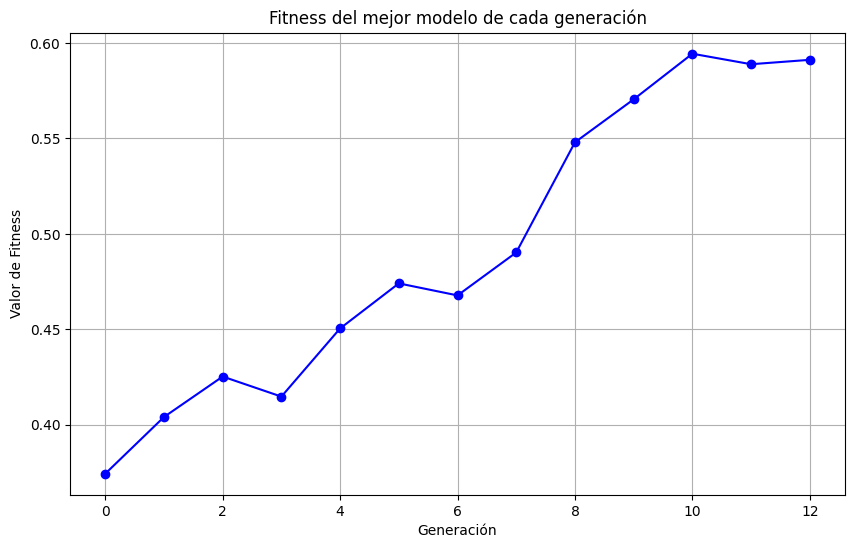

In [15]:
# Extraemos los valores de fitness de cada modelo
fitness_values = [model['fitness'] for model in top_models]

# Creamos gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(len(fitness_values)), fitness_values, marker='o', linestyle='-', color='b')
plt.title('Fitness del mejor modelo de cada generación')
plt.xlabel('Generación')
plt.ylabel('Valor de Fitness')

plt.grid(True)
plt.savefig('./evolucion_fitness.png')
plt.show()


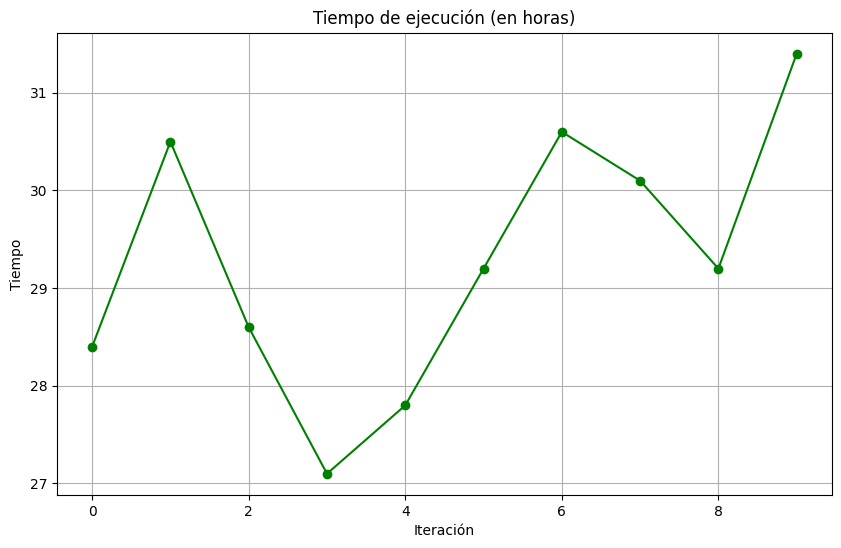

In [17]:
# Extraemos los valores de fitness de cada modelo
time_values = [
                28.4,
                30.5,
                28.6,
                27.1,
                27.8,
                29.2,
                30.6,
                30.1,
                29.2,
                31.4
               ]

# Creamos gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(len(time_values)), time_values, marker='o', linestyle='-', color='g')
plt.title('Tiempo de ejecución (en horas)')
plt.xlabel('Iteración')
plt.ylabel('Tiempo')

plt.grid(True)
plt.savefig('./tiempo_iteracion.png')
plt.show()